In [1]:
# loading the libraries 

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

### I examined the CSV file of Aldi job postings and identified errors in various columns.

### Observations on Salary (Lower-Upper) and Weekly Hours:
- Issues arise with salary (lower-upper) and weekly hours due to variations in the way this information is presented on the Aldi job postings page.
- Some job positions have NaN values for weekly hours, and the salary section contains discrepancies, including descriptions per hour, per week, or annually.
- Salaries may appear lower than expected due to daily rates (e.g., 'Quality Control Deputy' in the 'Quality Control Department' specifies £4.00 per hour per day).
- Some values exhibit problems, such as spaces between numbers, affecting the accuracy of the data.
- Salaries are occasionally listed per week instead of per year.
- Certain job positions lack information altogether.

### Specific Examples:
- In the 'Data Scientist' position, the second row and 'Salary Lower' show 57.0. This occurs because the actual amount is presented as '57, 130 pounds,' and the space between 57 and 130 leads to the issue.

In [3]:
## Completed code with extra columns and corrected parts that did not run before

def scrape_aldi_jobs(starting_page = 'head-office'):
    url = "https://www.aldirecruitment.co.uk/" + starting_page
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = []
    for link in soup.findAll('a'):
        new_link = link.get('href')
        if new_link != None and new_link.startswith('/head-office/'):
            new_link = new_link.replace('/head-office','')
            if new_link != '/':
                links.append(new_link)
    
    ## Lists that we use in our code
    department = []
    titles = []
    ubs = []
    lbs = []
    hours = []
    
    ## Extra columns
    h_l = []
    c_p = []
    c_m = []
    m_i = []

    for link in links:
        category_url = url + link
        page = requests.get(category_url)
        soup = BeautifulSoup(page.content, "html.parser")
        postings = soup.findAll("div", class_="c-career--dropdown")
        for posting in postings:
            # also grabbing the department information
            dep_name = link.replace('-',' ').replace('/','')
            department.append(dep_name)
            titles.append(posting.find("div", class_="c-career--dropdown__content").find('h2').text)
            details = posting.findAll("div", class_="c-job-details__content")
            for detail in details:
                detail_title = detail.find('span', class_="c-job-details__title").text
                detail_text = detail.find('div', class_="c-job-details__text").text
                if detail_title == 'Salary':
                    temp = detail_text.replace(',','')
                    temp = temp.replace('-','')
                    temp = temp.split()
                    salary_numbers = []
                    # there is a space between numbers so we have to fix it
                    for index in range(len(temp)):
                        if index < len(temp) - 1 and temp[index].startswith('£') and temp[index+1].isdigit():
                            salary_numbers.append(float(temp[index][1:]+temp[index+1]))
                        elif temp[index].startswith('£'):
                            salary_numbers.append(float(temp[index][1:]))
                    # salary may not be specified
                    if len(salary_numbers) > 0:
                        ## Salaries are sometimes specified as per week instead of per year
                        if 'per' in temp and 'week' in temp:
                            salary_numbers = [salary*52 for salary in salary_numbers]
                        # checking salaries specified as per hour instead of per week
                        elif 'per' in temp and 'hour' in temp:
                            salary_numbers = [salary*52*40 for salary in salary_numbers]
                        ubs.append(max(salary_numbers))
                        lbs.append(min(salary_numbers))
                    else:
                        ubs.append(None)
                        lbs.append(None)
                # some postings say "Benefits" instead of "Hours and benefits", and sometimes the spelling is capitalized differently
                elif detail_title.lower() == 'hours and benefits' or detail_title.lower() == 'benefits':
                    # some postings do not specify a number of hours per week
                    work_time = None
                    for s in detail_text.split():
                        if '-hour' in s:
                            work_time = s
                            # some postings write, e.g., 40-hour per week, some 40-hours per week
                            if '-hours' in s:
                                work_time = int(work_time.replace('-hours',''))
                            else:
                                work_time = int(work_time.replace('-hour',''))
                            # solving relevant problems regarding the working hours
                    if 'hours' in detail_text.split():
                        Index = detail_text.split().index('hours')
                        work_time = int(detail_text.split()[Index-1])
                    hours.append(work_time)
                    # adding extra columns about medical insurance, pension, maternity 
                    if 'insurance' or 'assurance' in detail_text.split():
                        if '6' in detail_text.split():
                            m_i.append("Private employee medical insurance after 6 months")
                        elif '4' in detail_text.split():
                            m_i.append("Private employee medical insurance after 4 years")
                        elif 'start.' in detail_text.split():
                            m_i.append("Private employee medical insurance when you start")
                        else:
                            m_i.append('')
                    if 'pension' or 'pension,' in detail_text.split():
                        c_p.append("Yes")
                    else:
                        c_p.append("No")
                    if 'maternity' or 'maternity,' in detail_text.split():
                        c_m.append("Possible")
                    else:
                        c_m.append("Not Possible")
                # some postings say 'Holiday allowance', 'Holiday', 'Holiday allownance',and other'Holiday Allowance'. Solving this problem
                if detail_title in ['Holiday allowance', 'Holiday', 'Holiday allownance','Holiday Allowance']:
                    days_off = None
                    if 'weeks’' in detail_text.split():
                        Index = detail_text.split().index('weeks’')
                        days_off = int(detail_text.split()[Index-1])
                    elif 'days' in detail_text.split():
                        Index = detail_text.split().index('days')
                        days_off = int(detail_text.split()[Index-1])/7
                    elif 'days’' in detail_text.split():
                        Index = detail_text.split().index('days’')
                        days_off = int(detail_text.split()[Index-1])/7
                    h_l.append(days_off)
                        
    job_data = pd.DataFrame(
        {'Department': department,
         'Job title': titles,
         'Salary lower': lbs,
         'Salary upper': ubs,
         'Weekly hours': hours,
         'Holiday Allowance': h_l,
         'Company pension': c_p,
         'Company maternity': c_m,
         'Medical Insurance': m_i
        })
    return job_data

- Upon careful examination of the additional details we've incorporated, each one contributes to providing additional motivation for potential applicants.
- In this scenario, the company endeavors to enhance the appeal of each offered position, aiming to attract a greater number of applications.
- By doing so, the company establishes a more competitive edge compared to other organizations in terms of the benefits associated with each job position.
- Moreover, the company strives to address a broad spectrum of market needs, including provisions for maternity and paternity leave, the company's pension scheme, and medical insurance.

In [ ]:
aldi_job_data = scrape_aldi_jobs()
aldi_job_data

## 1. Data Cleansing

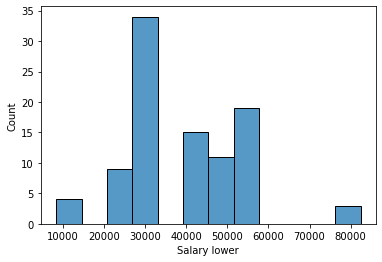

In [ ]:
# plot the data about 'Salary lower'
sns.histplot(aldi_job_data['Salary lower'], kde= False)
plt.show()

# It is obvious from the graph below that the average of the lower salary is close to 30000 and is referred to close 35 different job positions

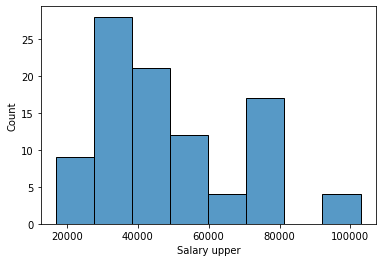

In [ ]:
# plot the data about 'Salary upper'
sns.histplot(aldi_job_data['Salary upper'], kde= False)
plt.show()

# from the graph below we can conclude that the upper salary for the majority of the job positions (close to 27) is around 40.000

In [ ]:
# use of the unique function to take a look at the values taken on by Department, and Job title
aldi_job_data["Department"].unique()

array(['national administration', 'regional administration',
       'national buying', 'corporate responsibility', 'customer service',
       'ecommerce', 'global business coordination', 'hr', 'it',
       'marketing communications', 'merchandising category',
       'national property', 'supply chain management',
       'quality assurance', 'quality control'], dtype=object)

In [ ]:
aldi_job_data["Job title"].unique()

array(['National Finance & Administration Manager',
       'National Tax Manager', 'Data Scientist',
       'National Finance & Administration Team Leader',
       'Technical Analyst', 'Tax Specialist',
       'National Administration Analyst',
       'Personal Assistant - National  Administration',
       'National  Administration Assistant',
       'Administration Support Assistant',
       'National Administration Apprentice',
       'Data Protection Team Leader', 'Data Protection Analyst',
       'Data Protection Assistant', 'Property Assistant',
       'Logistics Assistant', 'Trading Assistant',
       'Store Operations Assistant',
       'Regional Administration Personal Assistant',
       'Administration Support Assistant ',
       'Regional Administration Apprentice', 'National Buying Director',
       'National Buying Manager', 'National Buying Analyst',
       'Pricing Analyst', 'Pricing Assistant',
       'Personal Assistant - National Buying Department',
       'National Bu

In [ ]:
# below we have a FALSE output because there are no duplicates (use of the duplicate function in order to detect any duplicates)

dups = aldi_job_data.duplicated() 
print(dups.any()) 
print(aldi_job_data[dups]) 

False
Empty DataFrame
Columns: [Department, Job title, Salary lower, Salary upper, Weekly hours, Holiday Allowance, Company pension, Company maternity, Medical Insurance]
Index: []


In [ ]:
# lets now check the current size of dataset
print(aldi_job_data.shape) # seems logical regarding the dataframe above

(99, 9)


In [ ]:
# cheking for any dublicated columns

aldi_job_data.columns.duplicated()

array([False, False, False, False, False, False, False, False, False])

In [ ]:
# let's now check if there are any empty cells

aldi_job_data.isna().any()

Department           False
Job title            False
Salary lower          True
Salary upper          True
Weekly hours          True
Holiday Allowance    False
Company pension      False
Company maternity    False
Medical Insurance    False
dtype: bool

## 2. Data Imputation

In [ ]:
# load the necessary libraries

from sklearn import impute
import numpy as np

In [ ]:
# replacing all the missing values of the column 'Weekly hours' with the average of hours and reshaping the array in order to be able to change it

h_a = np.array(aldi_job_data['Weekly hours']).reshape(11, 9)
print(h_a)

[[50. 50. 40. 40. 40. 40. nan 40. 40.]
 [40. 30. 40. 40. 40. 40. 40. 40. 40.]
 [40. 40. 30. nan 50. 40. 40. 40. 40.]
 [40. 40. 40. 50. 40. 50. 40. 50. 50.]
 [40. 40. 40. 50. 50. 40. 40. nan nan]
 [40. 40. 40. nan 50. 50. 40. 40. 40.]
 [40. 40. 40. 50. 40. 40. 40. 40. 40.]
 [50. 50. 40. 40. 40. 40. 40. 30. 50.]
 [40. 50. 40. 40. 40. 50. 50. 50. 40.]
 [40. 50. 40. 40. 40. 40. 50. 40. 40.]
 [nan 50. 40. 40. 40. 40. 48. 20. 20.]]


In [ ]:
# the use of the mean in the missing values 

imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(h_a)
print(imp.transform(h_a))

[[50.         50.         40.         40.         40.         40.
  42.8        40.         40.        ]
 [40.         30.         40.         40.         40.         40.
  40.         40.         40.        ]
 [40.         40.         30.         43.33333333 50.         40.
  40.         40.         40.        ]
 [40.         40.         40.         50.         40.         50.
  40.         50.         50.        ]
 [40.         40.         40.         50.         50.         40.
  40.         39.         40.        ]
 [40.         40.         40.         43.33333333 50.         50.
  40.         40.         40.        ]
 [40.         40.         40.         50.         40.         40.
  40.         40.         40.        ]
 [50.         50.         40.         40.         40.         40.
  40.         30.         50.        ]
 [40.         50.         40.         40.         40.         50.
  50.         50.         40.        ]
 [40.         50.         40.         40.         40.  

In [ ]:
# now we are doing the same as above for both salary lower and salary upper

s_l = np.array(aldi_job_data['Salary lower']).reshape(11, 9)
print(s_l)

[[54285.  44660.  57130.  47100.  47100.  41950.  41200.  32075.  32075. ]
 [22310.   9828.  47100.  41200.  32075.  28755.  28755.  28755.  28755. ]
 [28755.  21210.   9828.      nan 54285.  41200.  41200.  32075.  32075. ]
 [32075.  22310.  22310.  54285.  32200.  54285.  32075.  54285.  46570. ]
 [32075.  32075.  25667.2 82415.  54285.  47100.  54285.  47100.  41200. ]
 [32200.  32075.  22310.      nan 82415.  54285.  54285.  47100.  41200. ]
 [32200.  32075.  32075.  44660.  54285.  47100.  47100.  41200.  29685. ]
 [82415.  54285.  54285.  47100.  32200.  32075.  27445.   9828.  54285. ]
 [32075.  54285.  32075.  41200.  32075.      nan 54285.  44000.  32075. ]
 [28755.  54285.  41200.  32075.  32075.  22310.  54285.  41200.  32075. ]
 [    nan 54285.  32075.  41200.  30350.  25670.  46435.   8320.  22401.6]]


In [ ]:
imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(s_l)
print(imp.transform(s_l))

[[54285.  44660.  57130.  47100.  47100.  41950.  41200.  32075.  32075. ]
 [22310.   9828.  47100.  41200.  32075.  28755.  28755.  28755.  28755. ]
 [28755.  21210.   9828.  47915.  54285.  41200.  41200.  32075.  32075. ]
 [32075.  22310.  22310.  54285.  32200.  54285.  32075.  54285.  46570. ]
 [32075.  32075.  25667.2 82415.  54285.  47100.  54285.  47100.  41200. ]
 [32200.  32075.  22310.  47915.  82415.  54285.  54285.  47100.  41200. ]
 [32200.  32075.  32075.  44660.  54285.  47100.  47100.  41200.  29685. ]
 [82415.  54285.  54285.  47100.  32200.  32075.  27445.   9828.  54285. ]
 [32075.  54285.  32075.  41200.  32075.  39473.  54285.  44000.  32075. ]
 [28755.  54285.  41200.  32075.  32075.  22310.  54285.  41200.  32075. ]
 [37714.5 54285.  32075.  41200.  30350.  25670.  46435.   8320.  22401.6]]


In [ ]:
s_u = np.array(aldi_job_data['Salary upper']).reshape(11, 9)
print(s_u)

[[ 79040.   93655.   74430.   54255.   54255.   50475.   45225.   37455.
   37455. ]
 [ 27450.   16952.   54255.   45225.   37455.   39330.   39330.   39330.
   39330. ]
 [ 39330.   30865.   16952.       nan  79040.   45225.   45225.   37455.
   37455. ]
 [ 37455.   27450.   27450.   79040.   46590.   79040.   37455.   79040.
   51580. ]
 [ 37455.   37455.   31137.6 102875.   79040.   54255.   70415.   54255.
   45225. ]
 [ 46590.   37455.   27450.       nan 102875.   79040.   70415.   54255.
   45225. ]
 [ 46590.   37455.   37455.   79040.   70415.   54255.   54255.   45225.
   36860. ]
 [102875.   79040.   70415.   54255.   46590.   37455.   30670.   16952.
   79040. ]
 [ 37455.   79040.   37455.   45225.   37455.       nan  79040.   79040.
   37455. ]
 [ 39330.   79040.   45225.   37455.   37455.   27450.   79040.   45225.
   37455. ]
 [     nan  79040.   37455.   45225.   36055.   31100.   50430.   28662.4
   26582.4]]


In [ ]:
imp = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(s_u)
print(imp.transform(s_u))

[[ 79040.          93655.          74430.          54255.
   54255.          50475.          45225.          37455.
   37455.        ]
 [ 27450.          16952.          54255.          45225.
   37455.          39330.          39330.          39330.
   39330.        ]
 [ 39330.          30865.          16952.          60288.33333333
   79040.          45225.          45225.          37455.
   37455.        ]
 [ 37455.          27450.          27450.          79040.
   46590.          79040.          37455.          79040.
   51580.        ]
 [ 37455.          37455.          31137.6        102875.
   79040.          54255.          70415.          54255.
   45225.        ]
 [ 46590.          37455.          27450.          60288.33333333
  102875.          79040.          70415.          54255.
   45225.        ]
 [ 46590.          37455.          37455.          79040.
   70415.          54255.          54255.          45225.
   36860.        ]
 [102875.          79040.          7041

## Now we can remove all the rows with missing values and check the shape of the data and see how our dataframe is transformed

print(aldi_job_data.shape) #
aldi_job_data.dropna(axis=0,inplace=True) #
print(aldi_job_data.shape)

## I won't run this code in order to get full results for the details below in every row

In [ ]:
# now I am gonna calculate the average salary for every job position (by combining the 2 salaries of 'lower' and 'upper' in every case)
# this creation (average salaries) is a feature of competitive intelligence when analyzing the posting data and could play a significant role in approaching more applicants

mean_salaries = (aldi_job_data[['Salary lower', 'Salary upper']].mean(axis=1))

In [ ]:
mean_salaries

0     66662.5
1     69157.5
2     65780.0
3     50677.5
4     50677.5
       ...   
94    33202.5
95    28385.0
96    48432.5
97    18491.2
98    24492.0
Length: 99, dtype: float64

In [ ]:
# now i am gonna create a new dataframe with the columns that i only want to use below (add the Average salaries and remove some other aspects from my previous dataframe)

aldi_job_data0 = pd.DataFrame({'Department' : aldi_job_data['Department'], 'Job title' : aldi_job_data['Job title'], 'Salary lower' : aldi_job_data['Salary lower'], 'Salary upper' : aldi_job_data['Salary upper'], 'Average salaries' : mean_salaries, 'Weekly hours' : aldi_job_data['Weekly hours']})

In [ ]:
aldi_job_data0

,Department,Job title,Salary lower,Salary upper,Average salaries,Weekly hours
0,national administration,National Finance & Administration Manager,54285.0,79040.0,66662.5,50.0
1,national administration,National Tax Manager,44660.0,93655.0,69157.5,50.0
2,national administration,Data Scientist,57130.0,74430.0,65780.0,40.0
3,national administration,National Finance & Administration Team Leader,47100.0,54255.0,50677.5,40.0
4,national administration,Technical Analyst,47100.0,54255.0,50677.5,40.0
...,...,...,...,...,...,...
94,quality assurance,Sampling Chef,30350.0,36055.0,33202.5,40.0
95,quality assurance,Sampling Assistant,25670.0,31100.0,28385.0,40.0
96,quality control,Quality Control Leader,46435.0,50430.0,48432.5,48.0
97,quality control,Quality Control Deputy,8320.0,28662.4,18491.2,20.0


In [ ]:
# I will groupby(Department) the above dataframe in order to make it applicable for my regression

aldi_job_data0_new = aldi_job_data0.groupby(by='Department').mean().round(1)

In [ ]:
aldi_job_data0_new

,Salary lower,Salary upper,Average salaries,Weekly hours
Department,,,,
corporate responsibility,43180.0,58247.5,50713.8,45.0
customer service,38134.4,47333.5,42734.0,44.0
ecommerce,45885.6,57506.7,51696.1,42.9
global business coordination,46954.4,59163.8,53059.1,42.5
hr,44005.0,56675.0,50340.0,41.7
it,42454.1,54781.5,48617.8,41.2
marketing communications,43180.0,58247.5,50713.8,45.0
merchandising category,39908.8,49793.8,44851.2,42.5
national administration,39292.0,50541.6,44916.8,40.8


In [ ]:
# now i will create a regression between departments and average salaries (hypothesis)

x = aldi_job_data0_new['Weekly hours']
y = aldi_job_data0_new['Average salaries']
x = sm.add_constant(x)
lm = sm.OLS(y, x).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       Average salaries   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     15.60
Date:                Thu, 04 Nov 2021   Prob (F-statistic):            0.00166
Time:                        00:14:15   Log-Likelihood:                -147.88
No. Observations:                  15   AIC:                             299.8
Df Residuals:                      13   BIC:                             301.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.118e+04   1.43e+04     -0.784   

/Users/georgekalfas/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Regression Analysis Conclusions

1. The constant coefficient value of -1.118e+04 indicates a negative starting point for our graph line.

2. The R-squared value of 0.545 suggests a moderately good fit for the model, with a higher value indicating a better fit (closer to 1).

3. The low p-value (Pr>|t| = 0.002) in the hypothesis test for the coefficient implies that we can reject the null hypothesis (coef!=0). Therefore, our hypothesis regarding an increase in average salaries due to more weekly hours is supported.

   - This indicates a linear association between the predictor (weekly hours) and the response (average salary).

4. The low p-value for the F-statistic (Prob (F-statistic): 0.00166) suggests rejecting the null hypothesis (β=0), further supporting the relationship between weekly hours and average salary.
